In [2]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
true_intercept = 1
true_slope = 2
size=100
x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5,size=size)

data = dict(x=x, y=y)

In [32]:
df=pd.read_csv("citadel-challenge-2.0/clean_data/tech_lse.csv")
df['past']=df['market_cap'].shift(1)
df['uk']=np.where(df['country_of_incorporation']=='United Kingdom', 1, 0)

In [33]:
df

,Unnamed: 0,year,month,ticker,list_date,company_name,icb_industry,icb_supersector,country_of_incorporation,market_cap,eps,p/e,p/s,datetime,past,uk
0,31,2017,11,ACC,2005-06-28,ACCESS INTELLIGENCE PLC,Technology,Technology,United Kingdom,12.760308,-0.08,-4.984495,0.251875,2017-11-01,NaN,1
1,100,2017,11,AMO,2004-06-09,AMINO TECHNOLOGIES PLC,Technology,Technology,United Kingdom,137.250417,0.19,9.895488,1.315068,2017-11-01,12.760308,1
2,1007,2017,11,KBT,2001-03-28,K3 BUSINESS TECHNOLOGY GROUP PLC,Technology,Technology,United Kingdom,71.935664,-0.20,-8.364612,2.744186,2017-11-01,137.250417,1
3,1746,2017,11,TEK,2014-04-04,TEKCAPITAL PLC,Technology,Technology,United Kingdom,12.796412,0.10,2.975910,0.163721,2017-11-01,71.935664,1
4,3356,2017,1,ETX,2007-11-28,E-THERAPEUTICS PLC,Pharmaceuticals & Biotechnology,Biotechnology,United Kingdom,22.737899,-0.04,-2.121073,0.000000,2017-01-01,12.796412,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,152540,2018,9,OMG,2001-04-10,OXFORD METRICS PLC,Technology,Technology,United Kingdom,94.930000,0.03,25.314667,0.256000,2018-09-01,9.390000,1
583,152799,2018,9,SGE,2013-06-10,SAGE GROUP PLC,Technology,Technology,United Kingdom,6360.300000,0.32,18.318836,1.701382,2018-09-01,94.930000,1
584,152806,2018,9,SND,2004-12-16,SANDERSON GROUP PLC,Technology,Technology,United Kingdom,50.380000,0.06,13.994444,0.533333,2018-09-01,6360.300000,1
585,153044,2018,9,TOOP,2016-05-10,TOOPLE PLC,Technology,Technology,United Kingdom,2.770000,-0.01,-0.290356,0.001583,2018-09-01,50.380000,1


In [37]:
#features as arrays
x_1=df["uk"].values
x_2=df["past"].values
y=df["market_cap"].values

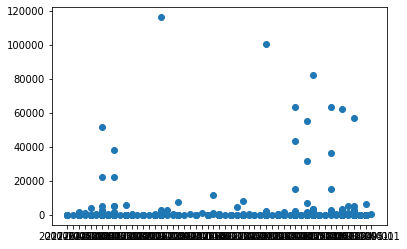

In [16]:
plt.scatter(df["datetime"],df["market_cap"])

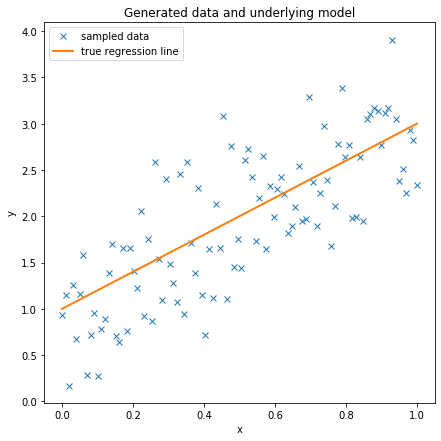

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [29]:
x1_coeff

x_1

In [38]:
type(x_1[0])

numpy.int64

In [43]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x1_coeff = Normal('x_1', 0, sd=20)
    x2_coeff=Normal('x_2', 0, sd=20)
    
    # Define likelihood
    likelihood = Normal('y', mu=intercept +x1_coeff * x_1, 
                        sd=sigma, observed=y)
    
    # Inference!
    trace = sample(progressbar=True) # draw posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_2, x_1, Intercept, sigma]
Sampling 2 chains:  36%|███▌      | 711/2000 [00:01<00:02, 584.32draws/s] 


RuntimeError: Chain 1 failed.

In [9]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    GLM.from_formula('y ~ x', data)
    trace = sample(progressbar=True, tune=1000, cores=4) # draw posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


//anaconda3/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

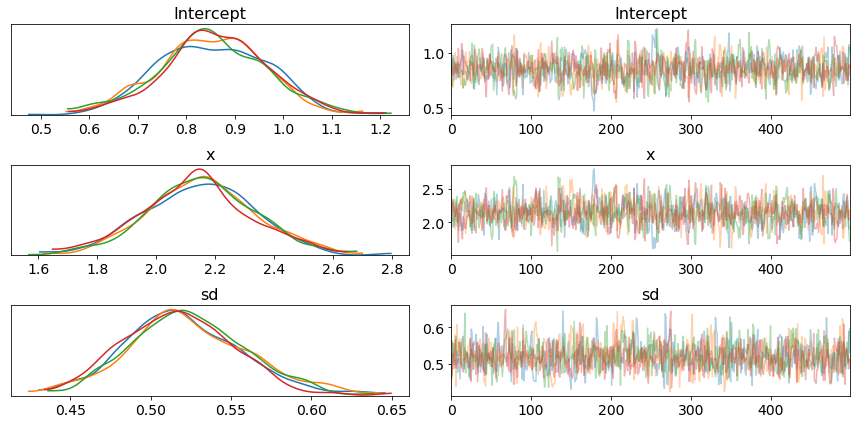

In [10]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

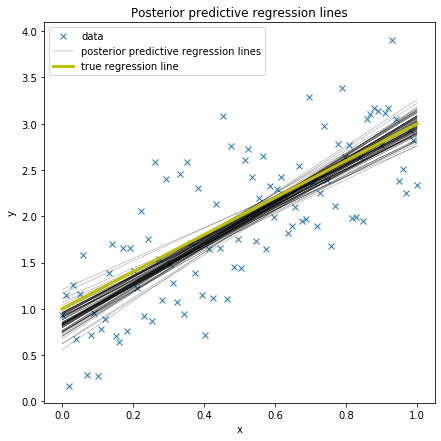

In [11]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plots.plot_posterior_predictive_glm(trace, samples=100, 
                                    label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');